In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
raw_data = pd.read_pickle('Predictors/raw_features.pkl')
target_df = (pd.read_excel('RESPONSE Main 1m.xls', skiprows=range(6))
               .rename(columns=lambda x: x.strip())
               .assign(**{'Effective date': lambda df: pd.to_datetime(df['Effective date'], errors='coerce')})
               .dropna(subset=['Effective date'])
               .set_index('Effective date'))

pd.set_option('display.max_columns', None)

In [36]:
# take intersection of available data
raw_data = raw_data.loc[raw_data.apply(pd.Series.first_valid_index).max():raw_data.apply(pd.Series.last_valid_index).min()].dropna(axis=1, how='all')

raw_data

,0GGH Bonds Global_price,0GGH Bonds Global_volume,EUNK Equities Europe_price,EUNK Equities Europe_volume,Euribor c2 Futures Historical Data_price,Euribor c2 Futures Historical Data_volume,Euro Short-Term Rate Futures Historical Data_price,Euro Short-Term Rate Futures Historical Data_volume,IEAC Bonds Europe_price,IEAC Bonds Europe_volume,ISSUSW Equities Global_price,ISSUSW Equities Global_volume,stooq eurindex_price,SXRP ETF Stock Price History_price,SXRP ETF Stock Price History_volume,TCRS Term Structure_price,TCRS Term Structure_volume,VSTOXX 50 Volatility_price,XTC5 iTraxx Cross_price,XTC5 iTraxx Cross_volume,iTraxx Main Index_price
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,4.512,100.0,60.05,56630.0,97.73,87520.0,99.31,0.0,113.10,7670000.0,8.77,115620.0,172.418,122.97,50.0,98.17,120.0,24.83,36.76,600.0,128.120778
2022-11-01,4.534,110.0,60.37,34360.0,97.73,87950.0,99.46,0.0,113.80,212810.0,8.81,175400.0,172.067,123.10,100.0,98.34,120.0,24.47,36.62,410.0,126.919584
2022-11-02,4.511,70.0,60.24,44060.0,97.71,98850.0,99.45,0.0,113.86,31840.0,8.77,81090.0,171.808,122.96,1300.0,98.31,120.0,24.70,36.62,280.0,126.914286
2022-11-03,4.472,150.0,59.65,11730.0,97.71,106740.0,99.45,0.0,113.29,453690.0,8.68,108610.0,172.752,122.31,660.0,98.30,120.0,23.77,36.80,280.0,128.778985
2022-11-04,4.476,200.0,60.67,51120.0,97.70,81430.0,99.45,0.0,113.68,457250.0,8.63,142270.0,174.163,122.07,340.0,98.40,120.0,22.91,36.47,350.0,124.652279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,4.644,2610.0,75.58,37060.0,96.30,184390.0,96.08,10.0,117.85,640810.0,10.34,485910.0,177.650,126.14,320.0,105.93,0.0,18.47,32.16,600.0,56.072945
2024-04-18,4.641,1290.0,75.79,20770.0,96.29,193030.0,96.08,10.0,117.92,613250.0,10.35,327570.0,177.371,126.06,2120.0,106.00,0.0,17.52,32.02,6070.0,56.382846
2024-04-19,4.643,164110.0,75.70,33510.0,96.29,260820.0,96.08,10.0,117.78,362360.0,10.31,103960.0,178.049,125.94,320.0,106.02,0.0,18.19,32.00,160.0,56.026593


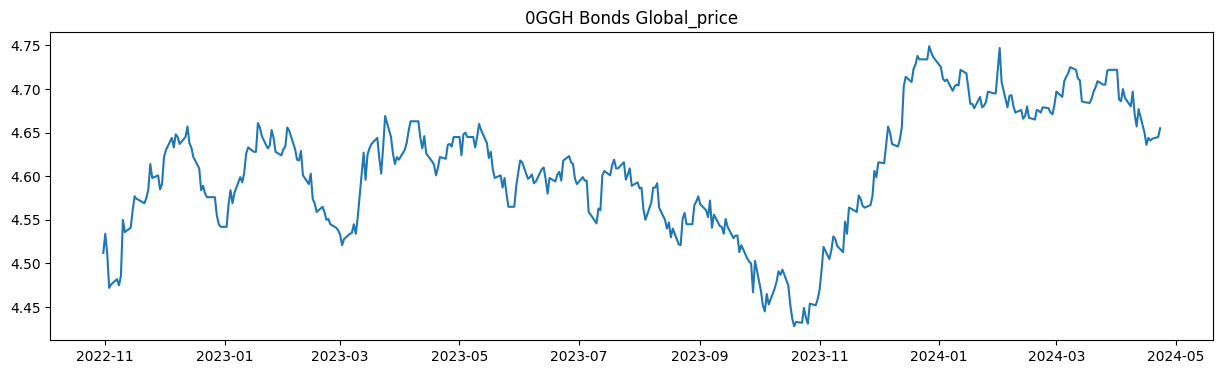

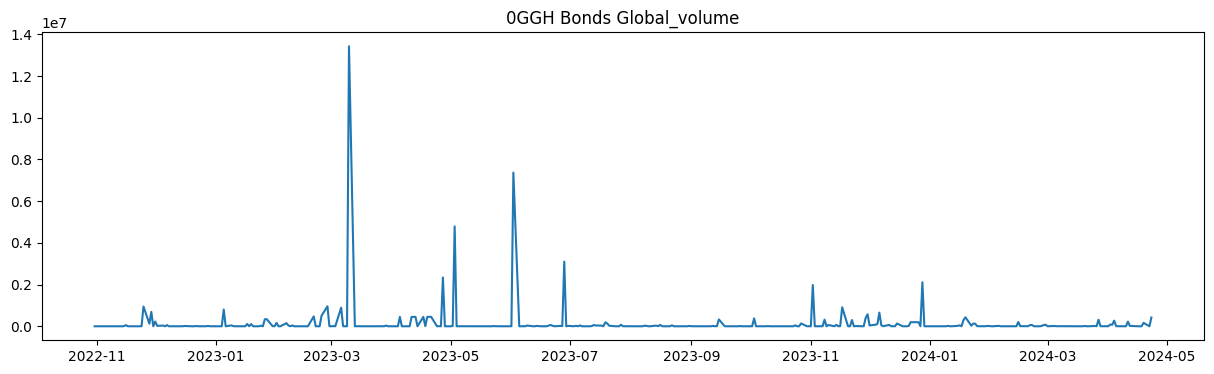

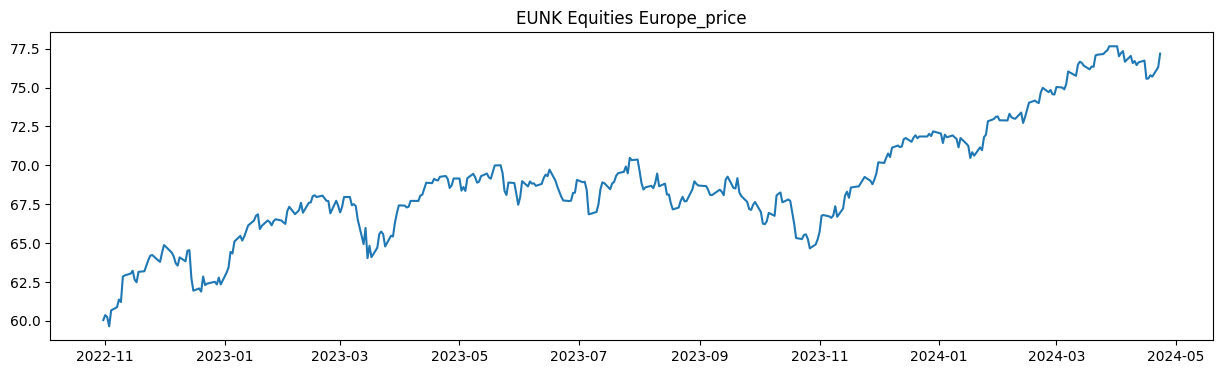

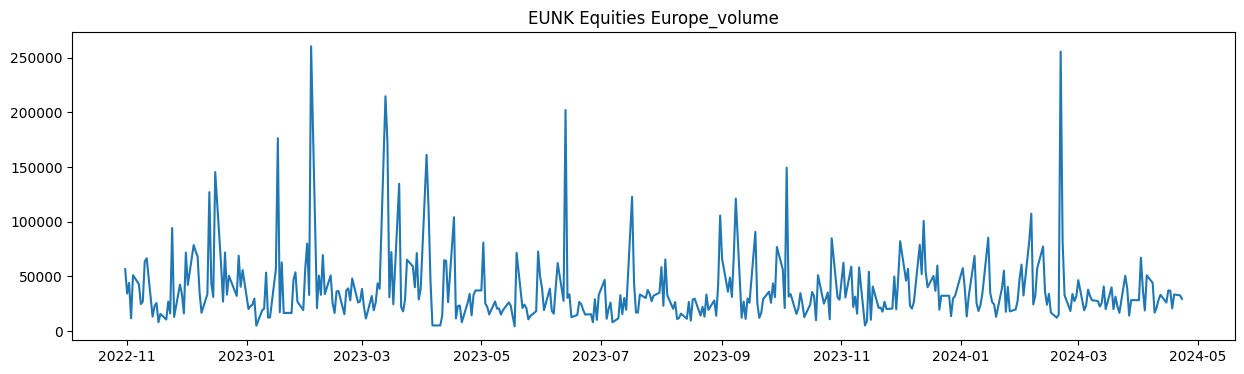

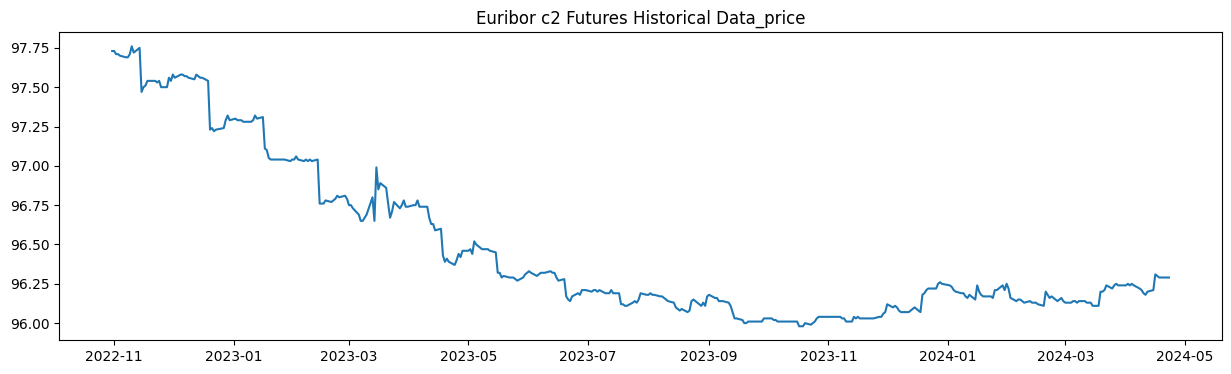

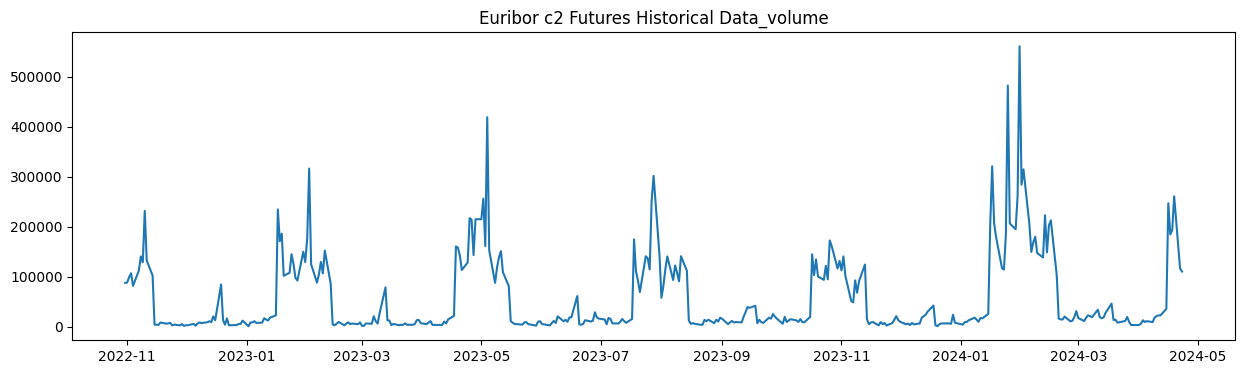

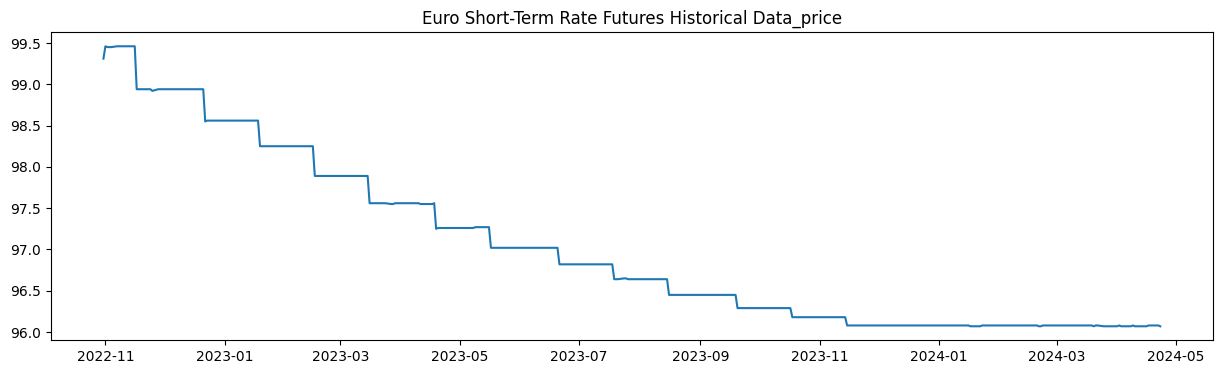

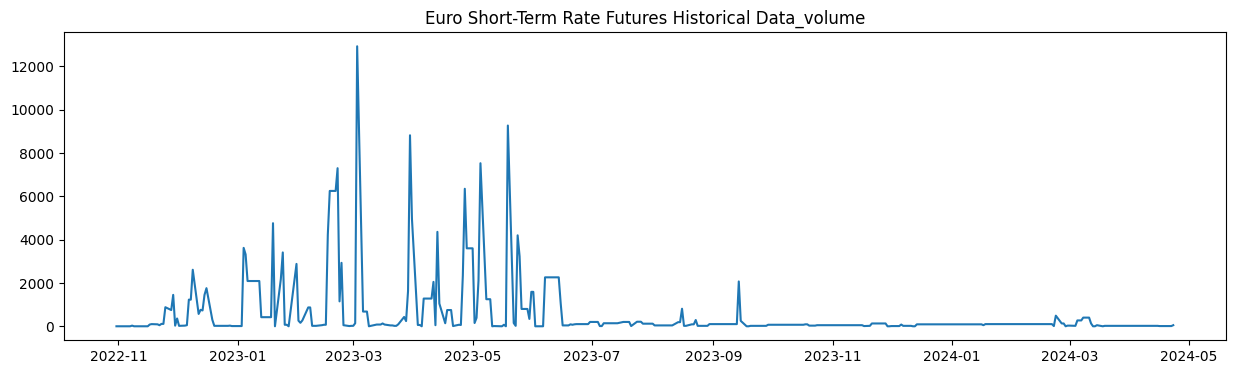

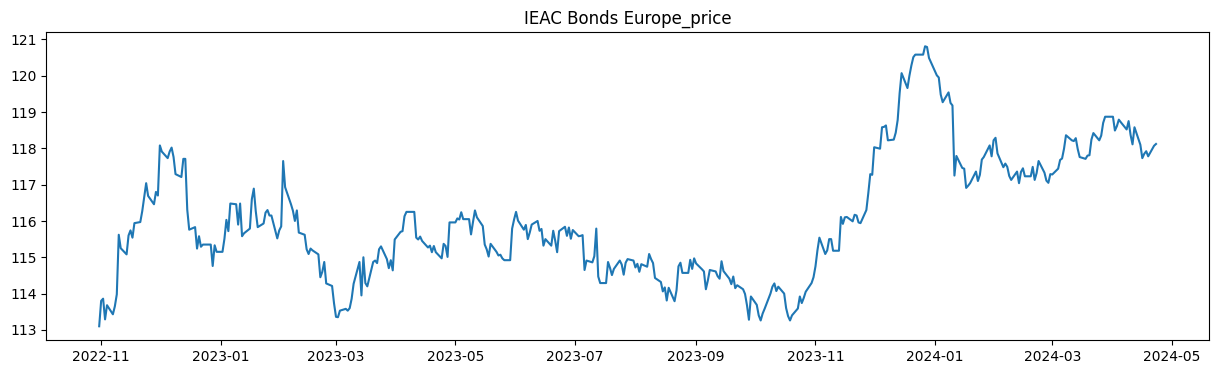

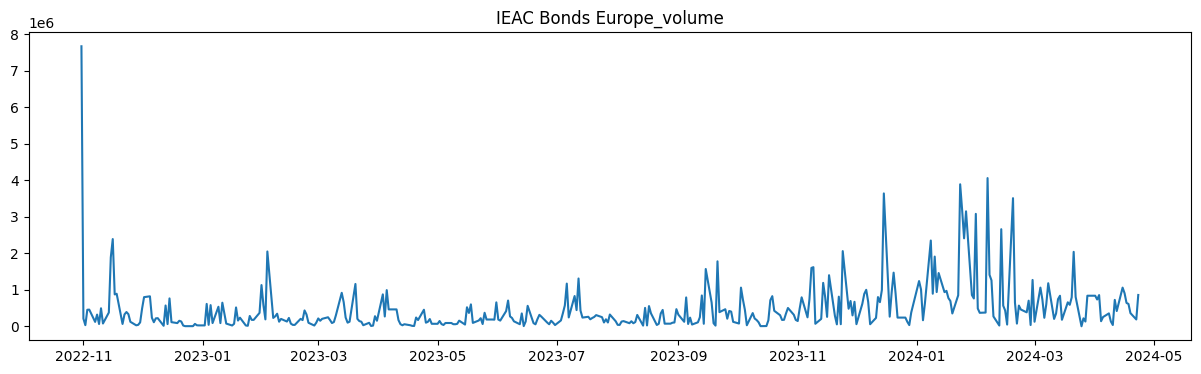

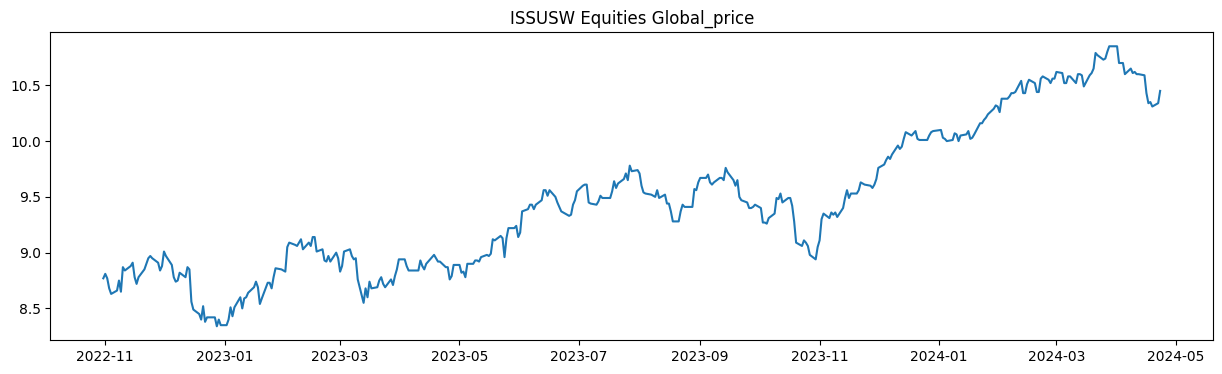

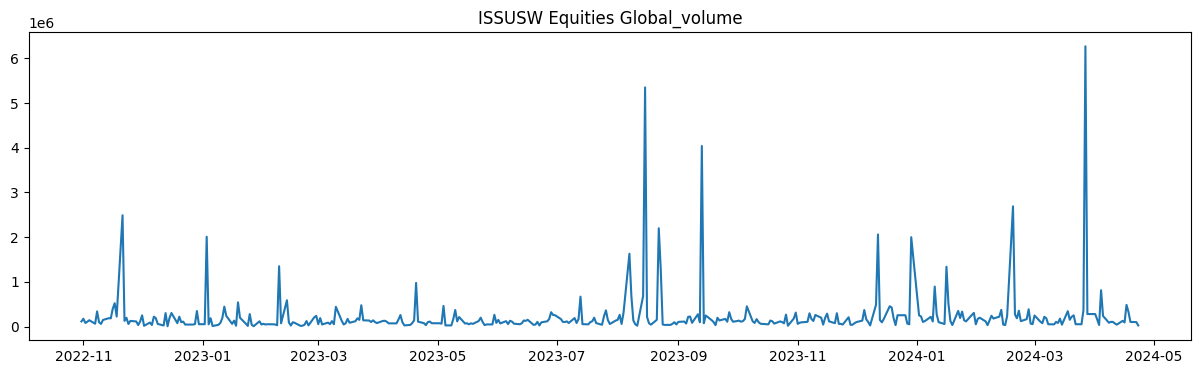

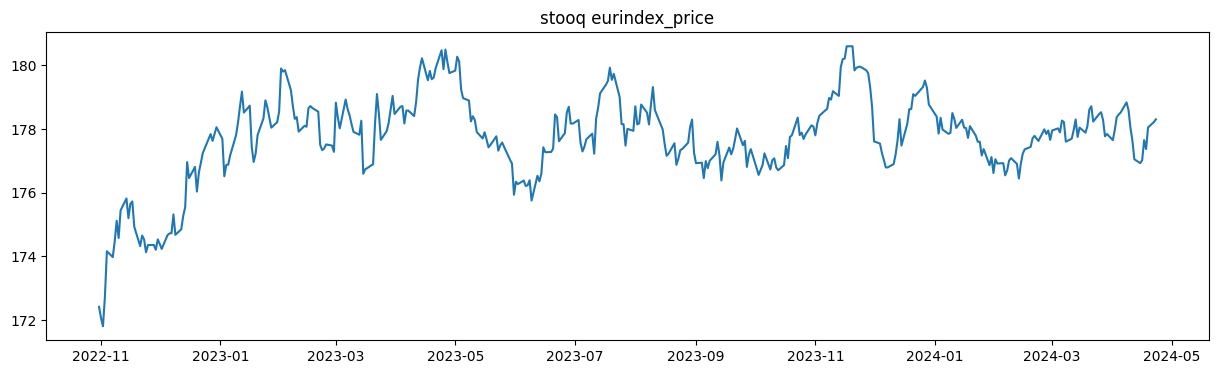

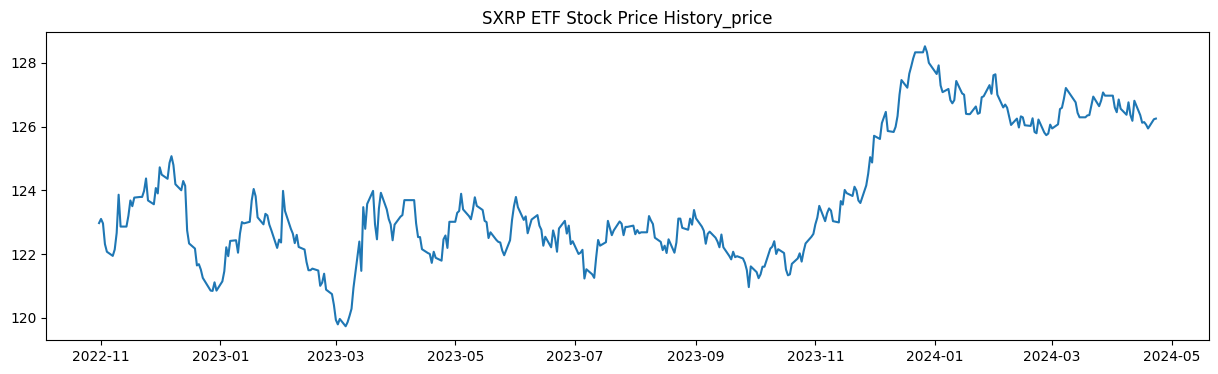

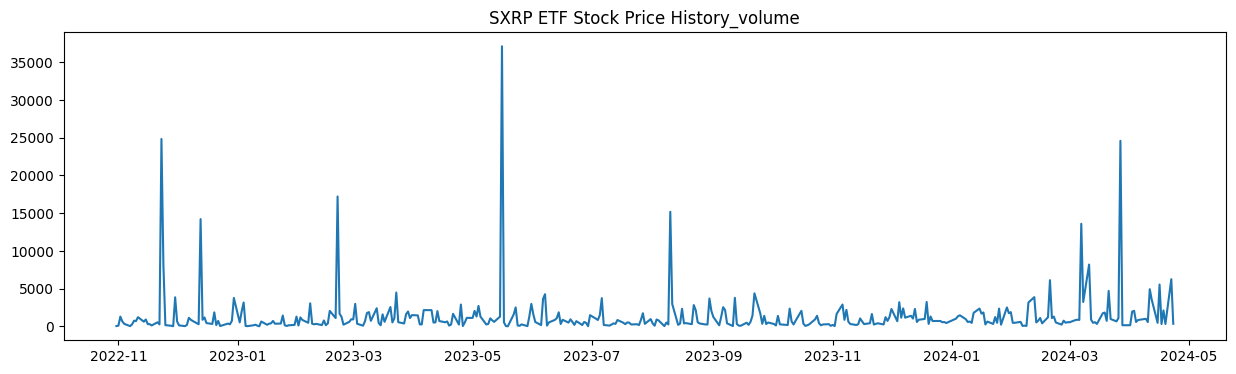

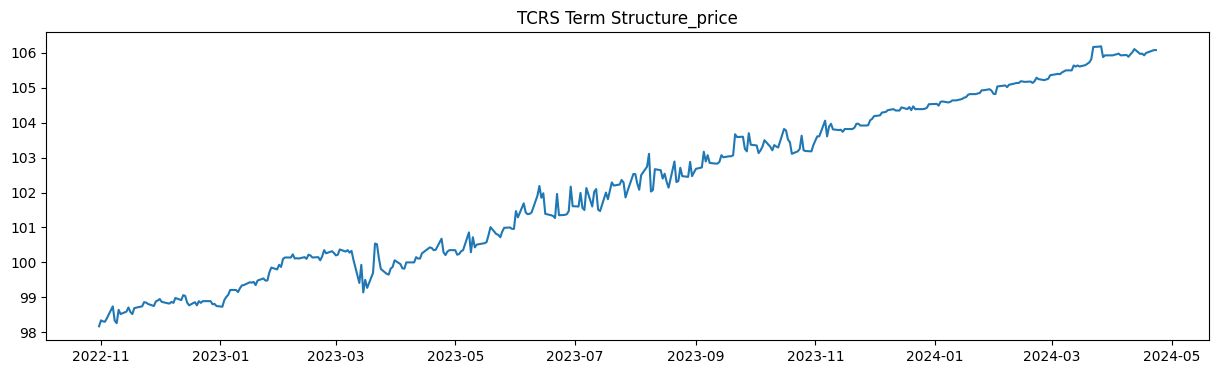

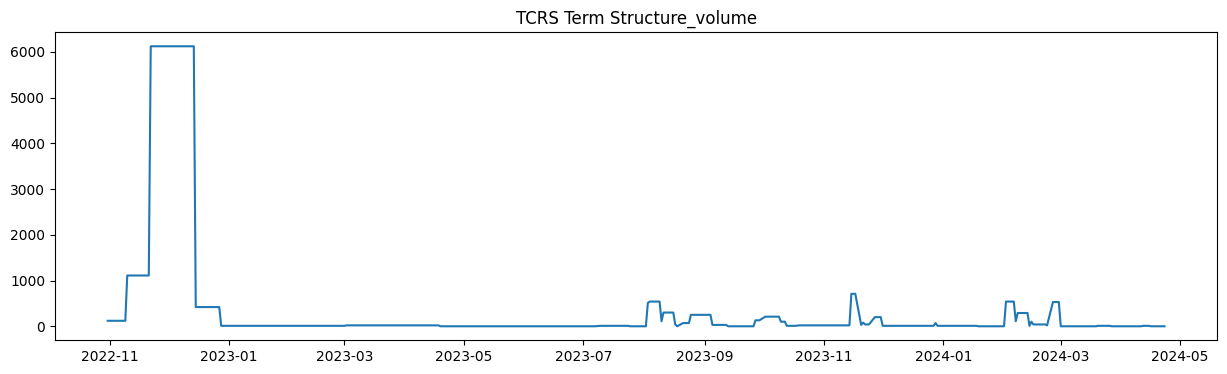

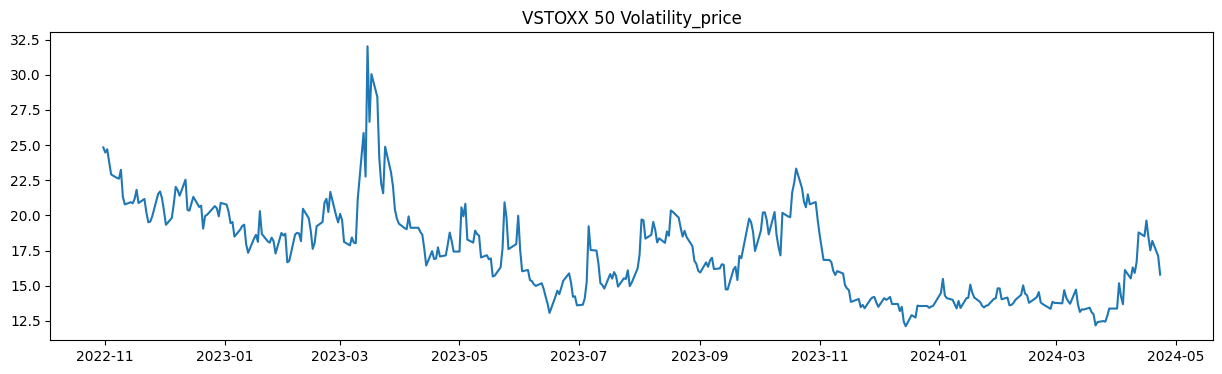

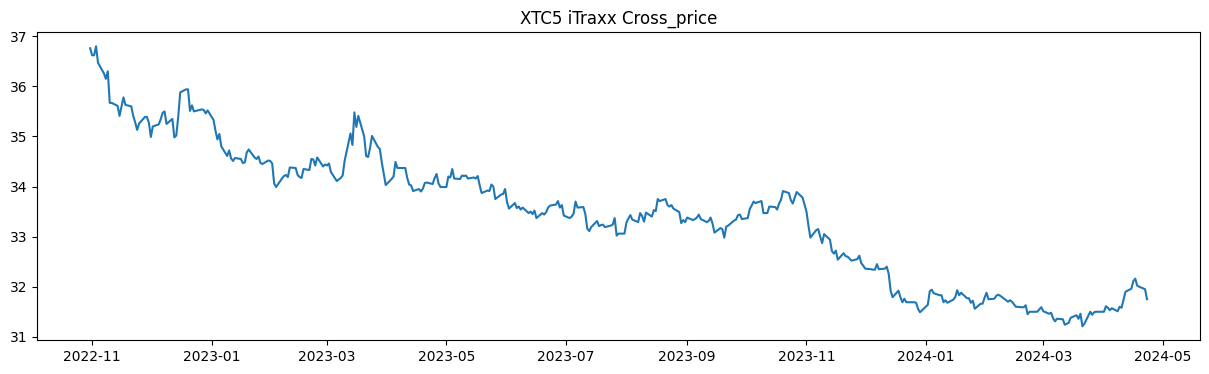

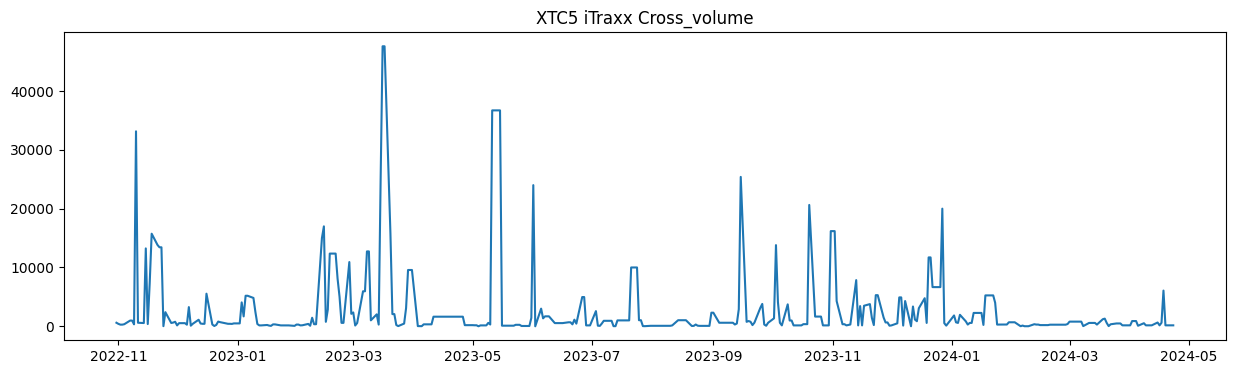

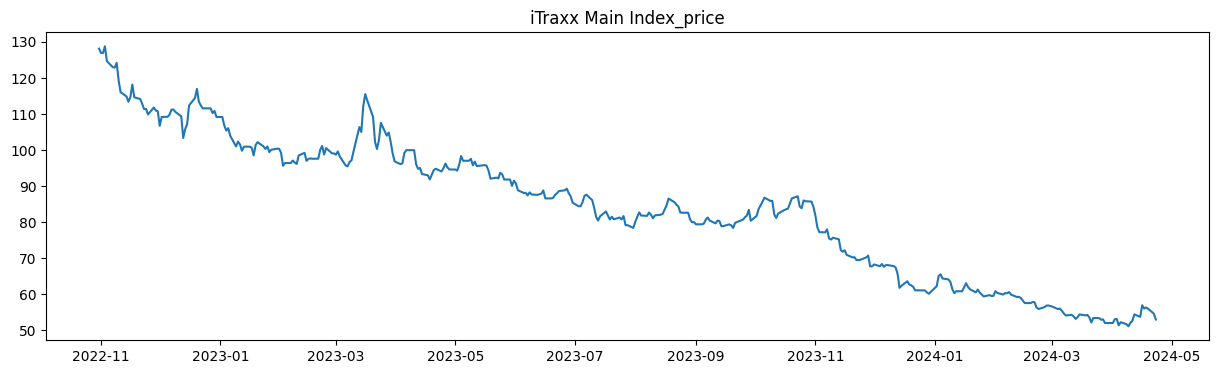

In [37]:
for column in raw_data.columns:
    plt.figure(figsize=(15, 4))
    plt.plot(raw_data.index, raw_data[column])
    plt.title(column)
    plt.show()

In [38]:
adjusted_data_df = raw_data + 0.000001

# log returns bc normality and stationarity

ln_returns = np.log(adjusted_data_df / adjusted_data_df.shift(1))
ln_returns = ln_returns.dropna()

ln_returns.columns = [col + '_returns' for col in ln_returns.columns]

In [39]:
ln_returns

,0GGH Bonds Global_price_returns,0GGH Bonds Global_volume_returns,EUNK Equities Europe_price_returns,EUNK Equities Europe_volume_returns,Euribor c2 Futures Historical Data_price_returns,Euribor c2 Futures Historical Data_volume_returns,Euro Short-Term Rate Futures Historical Data_price_returns,Euro Short-Term Rate Futures Historical Data_volume_returns,IEAC Bonds Europe_price_returns,IEAC Bonds Europe_volume_returns,ISSUSW Equities Global_price_returns,ISSUSW Equities Global_volume_returns,stooq eurindex_price_returns,SXRP ETF Stock Price History_price_returns,SXRP ETF Stock Price History_volume_returns,TCRS Term Structure_price_returns,TCRS Term Structure_volume_returns,VSTOXX 50 Volatility_price_returns,XTC5 iTraxx Cross_price_returns,XTC5 iTraxx Cross_volume_returns,iTraxx Main Index_price_returns
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,0.004864,0.095310,0.005315,-0.499646,0.000000,0.004901,0.001509,0.000000,0.006170,-3.584672,0.004551,0.416760,-0.002038,0.001057,0.693147,0.001730,0.0,-0.014605,-0.003816,-0.380772,-0.009420
2022-11-02,-0.005086,-0.451985,-0.002156,0.248659,-0.000205,0.116835,-0.000101,0.000000,0.000527,-1.899676,-0.004551,-0.771509,-0.001506,-0.001138,2.564949,-0.000305,0.0,0.009355,0.000000,-0.381368,-0.000042
2022-11-03,-0.008683,0.762140,-0.009842,-1.323403,0.000000,0.076792,0.000000,0.000000,-0.005019,2.656691,-0.010315,0.292204,0.005479,-0.005300,-0.677880,-0.000102,0.0,-0.038379,0.004903,0.000000,0.014586
2022-11-04,0.000894,0.287682,0.016955,1.472026,-0.000102,-0.270652,0.000000,0.000000,0.003437,0.007816,-0.005777,0.269963,0.008135,-0.001964,-0.663294,0.001017,0.0,-0.036851,-0.009008,0.223144,-0.032570
2022-11-07,0.001340,-1.203973,0.003455,-0.173674,-0.000102,0.322231,0.000101,0.000000,-0.002202,-1.325728,0.003470,-0.782570,-0.001063,-0.001066,-2.140066,0.003449,0.0,-0.010972,-0.005775,1.019363,-0.013391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,0.001724,1.390133,0.000265,-0.002964,-0.000104,-0.291930,0.000104,0.000000,0.001019,-0.347972,-0.008666,1.655792,0.003547,0.000159,-2.853232,-0.000472,0.0,-0.060911,0.001556,1.321756,-0.016189
2024-04-18,-0.000646,-0.704708,0.002775,-0.579029,-0.000104,0.045793,0.000000,0.000000,0.000594,-0.043960,0.000967,-0.394322,-0.001572,-0.000634,1.890850,0.000661,0.0,-0.052805,-0.004363,2.314184,0.005512
2024-04-19,0.000431,4.845895,-0.001188,0.478334,0.000000,0.300985,0.000000,0.000000,-0.001188,-0.526134,-0.003872,-1.147696,0.003815,-0.000952,-1.890850,0.000189,0.0,0.037529,-0.000625,-3.635940,-0.006339


In [40]:
sigma = ln_returns.rolling(window=21).std() # 21 is approximately the number of monthly trading days, found in notebook.

sigma.columns = [col + '_vol' for col in sigma.columns]

sigma

,0GGH Bonds Global_price_returns_vol,0GGH Bonds Global_volume_returns_vol,EUNK Equities Europe_price_returns_vol,EUNK Equities Europe_volume_returns_vol,Euribor c2 Futures Historical Data_price_returns_vol,Euribor c2 Futures Historical Data_volume_returns_vol,Euro Short-Term Rate Futures Historical Data_price_returns_vol,Euro Short-Term Rate Futures Historical Data_volume_returns_vol,IEAC Bonds Europe_price_returns_vol,IEAC Bonds Europe_volume_returns_vol,ISSUSW Equities Global_price_returns_vol,ISSUSW Equities Global_volume_returns_vol,stooq eurindex_price_returns_vol,SXRP ETF Stock Price History_price_returns_vol,SXRP ETF Stock Price History_volume_returns_vol,TCRS Term Structure_price_returns_vol,TCRS Term Structure_volume_returns_vol,VSTOXX 50 Volatility_price_returns_vol,XTC5 iTraxx Cross_price_returns_vol,XTC5 iTraxx Cross_volume_returns_vol,iTraxx Main Index_price_returns_vol
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,0.003174,2.809185,0.005369,0.593234,0.000270,0.627352,0.000066,0.151257,0.002336,2.138055,0.006535,1.471918,0.002026,0.002372,1.911178,0.001102,7.208232,0.062330,0.003308,1.318952,0.021536
2024-04-18,0.003135,2.717993,0.005416,0.599193,0.000272,0.627382,0.000061,0.151257,0.002340,2.137006,0.006456,1.473124,0.001922,0.002375,1.947955,0.001107,6.192770,0.063867,0.003487,1.400543,0.021294
2024-04-19,0.003121,2.787892,0.004923,0.604321,0.000272,0.608726,0.000057,0.151257,0.002201,2.128172,0.005560,1.494550,0.002118,0.002316,1.946135,0.001095,6.192770,0.061565,0.002872,1.481785,0.020366


#### aggregaring covariates

In [41]:
all_features = pd.concat([raw_data, sigma, ln_returns], axis=1)

In [42]:
all_features = all_features[:-200] # taking subset to mitigate significant look-ahead

In [43]:
all_features

,0GGH Bonds Global_price,0GGH Bonds Global_volume,EUNK Equities Europe_price,EUNK Equities Europe_volume,Euribor c2 Futures Historical Data_price,Euribor c2 Futures Historical Data_volume,Euro Short-Term Rate Futures Historical Data_price,Euro Short-Term Rate Futures Historical Data_volume,IEAC Bonds Europe_price,IEAC Bonds Europe_volume,ISSUSW Equities Global_price,ISSUSW Equities Global_volume,stooq eurindex_price,SXRP ETF Stock Price History_price,SXRP ETF Stock Price History_volume,TCRS Term Structure_price,TCRS Term Structure_volume,VSTOXX 50 Volatility_price,XTC5 iTraxx Cross_price,XTC5 iTraxx Cross_volume,iTraxx Main Index_price,0GGH Bonds Global_price_returns_vol,0GGH Bonds Global_volume_returns_vol,EUNK Equities Europe_price_returns_vol,EUNK Equities Europe_volume_returns_vol,Euribor c2 Futures Historical Data_price_returns_vol,Euribor c2 Futures Historical Data_volume_returns_vol,Euro Short-Term Rate Futures Historical Data_price_returns_vol,Euro Short-Term Rate Futures Historical Data_volume_returns_vol,IEAC Bonds Europe_price_returns_vol,IEAC Bonds Europe_volume_returns_vol,ISSUSW Equities Global_price_returns_vol,ISSUSW Equities Global_volume_returns_vol,stooq eurindex_price_returns_vol,SXRP ETF Stock Price History_price_returns_vol,SXRP ETF Stock Price History_volume_returns_vol,TCRS Term Structure_price_returns_vol,TCRS Term Structure_volume_returns_vol,VSTOXX 50 Volatility_price_returns_vol,XTC5 iTraxx Cross_price_returns_vol,XTC5 iTraxx Cross_volume_returns_vol,iTraxx Main Index_price_returns_vol,0GGH Bonds Global_price_returns,0GGH Bonds Global_volume_returns,EUNK Equities Europe_price_returns,EUNK Equities Europe_volume_returns,Euribor c2 Futures Historical Data_price_returns,Euribor c2 Futures Historical Data_volume_returns,Euro Short-Term Rate Futures Historical Data_price_returns,Euro Short-Term Rate Futures Historical Data_volume_returns,IEAC Bonds Europe_price_returns,IEAC Bonds Europe_volume_returns,ISSUSW Equities Global_price_returns,ISSUSW Equities Global_volume_returns,stooq eurindex_price_returns,SXRP ETF Stock Price History_price_returns,SXRP ETF Stock Price History_volume_returns,TCRS Term Structure_price_returns,TCRS Term Structure_volume_returns,VSTOXX 50 Volatility_price_returns,XTC5 iTraxx Cross_price_returns,XTC5 iTraxx Cross_volume_returns,iTraxx Main Index_price_returns
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-31,4.512,100.0,60.05,56630.0,97.73,87520.0,99.31,0.0,113.10,7670000.0,8.77,115620.0,172.418,122.97,50.0,98.17,120.0,24.83,36.76,600.0,128.120778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,4.534,110.0,60.37,34360.0,97.73,87950.0,99.46,0.0,113.80,212810.0,8.81,175400.0,172.067,123.10,100.0,98.34,120.0,24.47,36.62,410.0,126.919584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004864,0.095310,0.005315,-0.499646,0.000000,0.004901,0.001509,0.0,0.006170,-3.584672,0.004551,0.416760,-0.002038,0.001057,0.693147,0.001730,0.000000,-0.014605,-0.003816,-0.380772,-0.009420
2022-11-02,4.511,70.0,60.24,44060.0,97.71,98850.0,99.45,0.0,113.86,31840.0,8.77,81090.0,171.808,122.96,1300.0,98.31,120.0,24.70,36.62,280.0,126.914286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005086,-0.451985,-0.002156,0.248659,-0.000205,0.116835,-0.000101,0.0,0.000527,-1.899676,-0.004551,-0.771509,-0.001506,-0.001138,2.564949,-0.000305,0.000000,0.009355,0.000000,-0.381368,-0.000042
2022-11-03,4.472,150.0,59.65,11730.0,97.71,106740.0,99.45,0.0,113.29,453690.0,8.68,108610.0,172.752,122.31,660.0,98.30,120.0,23.77,36.80,280.0,128.778985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008683,0.762140,-0.009842,-1.323403,0.000000,0.076792,0.000000,0.0,-0.005019,2.656691,-0.010315,0.292204,0.005479,-0.005300,-0.677880,-0.000102,0.000000,-0.0383

#### Feature Selection

In [44]:
y = target_df['ITraxx/Cboe Europe Main 1-Month Volatility Index (BP Volatility)'].shift(-1)
X = all_features.dropna()

In [45]:
intersection = y.index.intersection(X.index)

y_aligned = y.reindex(intersection)
X_aligned = X.reindex(intersection)

Shape of importance_df: (63, 2)
                                              feature  importance
17                         VSTOXX 50 Volatility_price    0.162109
15                          TCRS Term Structure_price    0.119684
22               0GGH Bonds Global_volume_returns_vol    0.081186
20                            iTraxx Main Index_price    0.064922
2                          EUNK Equities Europe_price    0.051272
18                            XTC5 iTraxx Cross_price    0.042836
38             VSTOXX 50 Volatility_price_returns_vol    0.042125
31           ISSUSW Equities Global_price_returns_vol    0.034789
35    SXRP ETF Stock Price History_volume_returns_vol    0.032700
33                   stooq eurindex_price_returns_vol    0.025992
5           Euribor c2 Futures Historical Data_volume    0.025454
19                           XTC5 iTraxx Cross_volume    0.023239
41                iTraxx Main Index_price_returns_vol    0.022975
40               XTC5 iTraxx Cross_volume_re

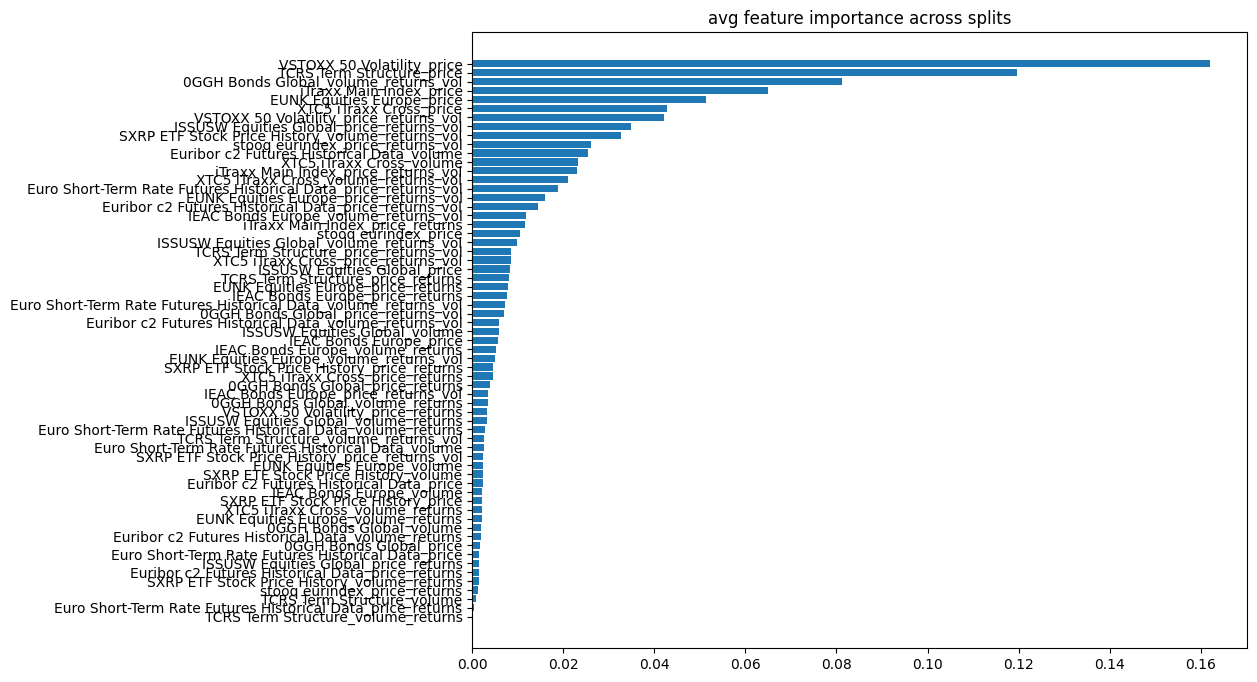

In [46]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
feature_importances = np.zeros((n_splits, X_aligned.shape[1]))

for i, (train_index, test_index) in enumerate(tscv.split(X_aligned)):
    X_train, X_test = X_aligned.iloc[train_index], X_aligned.iloc[test_index]
    Y_train, Y_test = y_aligned.iloc[train_index], y_aligned.iloc[test_index]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, Y_train)
    feature_importances[i, :] = rf_model.feature_importances_

average_importances = feature_importances.mean(axis=0)
feature_names = X_aligned.columns

# rank features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': average_importances
}).sort_values(by='importance', ascending=False)

# Print the shape of importance_df and the first few rows for debugging
print(f"Shape of importance_df: {importance_df.shape}")
print(importance_df.head(20))

# select the top 15 features
top_features = importance_df.head(15)
selected_features = X_aligned[top_features['feature']]

# Print the selected features to debug
print(f"Shape of selected_features: {selected_features.shape}")
print(selected_features.head())

# Ensure that the selected features are unique and check their count
unique_selected_features = top_features['feature'].unique()
print(f"Number of unique selected features: {len(unique_selected_features)}")
print(unique_selected_features)

# re-index
top_features = top_features.reset_index(drop=True)

plt.figure(figsize=(10, 8))
plt.title('avg feature importance across splits')
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.show()


In [47]:
selected_features.to_pickle('features.pkl')

db x-trackers II iTraxx Crossover 5y Short UCITS (XTC5)

Think about modelling the term structure, premias, relationships etc. perhaps euro / global also, and a merton model proxy. Could even take the difference in corp and govvies to remove risks.

Chosen features via random forest, fitted on subset of a universe of ETFs and Indices range: (01/11/22 - 18/07/23)

| Rank | Feature Description                                              | Value |
|------|------------------------------------------------------------------|-------|
| 0    | Euro Stoxx 50 Implied Vol                                        | 0.162 |
| 1    | Term Structure of European Credit Spreads                        | 0.120 |
| 2    | Global Investment Grade Corporate Bonds Volatility               | 0.081 |
| 3    | iTraxx Europe Main CDS Price                                     | 0.065 |
| 4    | European Equities Index Level                                    | 0.051 |
| 5    | iTraxx Europe Crossover CDS Price                                | 0.043 |
| 6    | Volatility of Euro Stoxx 50 Implied Volatility                   | 0.042 |
| 7    | Global Developed Equities Index Volatility                       | 0.035 |
| 8    | Historical Stock Price Volatility of SXRP ETF                    | 0.033 |
| 9    | Volatility of STOOQ EUR Index                                    | 0.026 |
| 10   | Volume of Euribor 2-Month Futures                                | 0.025 |
| 11   | Volume of iTraxx Crossover CDS                                   | 0.023 |
| 12   | Realised Vol of iTraxx Europe Main Index                         | 0.023 |
| 13   | Volatility of iTraxx Crossover Index                             | 0.021 |
| 14   | Volume of Euro Short-Term Rate Futures Historical Data           | 0.019 |



In [48]:
top_features

,feature,importance
0,VSTOXX 50 Volatility_price,0.162109
1,TCRS Term Structure_price,0.119684
2,0GGH Bonds Global_volume_returns_vol,0.081186
3,iTraxx Main Index_price,0.064922
4,EUNK Equities Europe_price,0.051272
5,XTC5 iTraxx Cross_price,0.042836
6,VSTOXX 50 Volatility_price_returns_vol,0.042125
7,ISSUSW Equities Global_price_returns_vol,0.034789
8,SXRP ETF Stock Price History_volume_returns_vol,0.032700
9,stooq eurindex_price_returns_vol,0.025992
